In [1]:
import matplotlib.pyplot as plt
import nest
import nest.raster_plot
import numpy as np
from dipde.internals.internalpopulation import InternalPopulation
from dipde.internals.externalpopulation import ExternalPopulation
from dipde.internals.simulation import Simulation
from dipde.internals.connection import Connection as Connection
%matplotlib inline

In [2]:
def LambertWm1(x):
    nest.sli_push(x)
    nest.sli_run('LambertWm1')
    y = nest.sli_pop()
    return y
def ComputePSPnorm(tauMem, CMem, tauSyn):
    a = (tauMem / tauSyn)
    b = (1.0 / tauSyn - 1.0 / tauMem)
    # time of maximum
    t_max = 1.0 / b * (-LambertWm1(-np.exp(-1.0 / a) / a) - 1.0 / a)
    # maximum of PSP for current of unit amplitude
    return (np.exp(1.0) / (tauSyn * CMem * b) *
            ((np.exp(-t_max / tauMem) - np.exp(-t_max / tauSyn)) / b -
             t_max * np.exp(-t_max / tauSyn)))  

In [3]:
# Spiking Network - Settings 
N = 50 
u_rest= 0. #-1.  #-70.  resting potential [mV]
u_reset = 0. #-1.  #-65. reset potential [mV]
u_th= 20.  #-55.  firing threshold [mV]
t_m = 20. # time constante [ms]
C_m = 1. #Capacitance [pF]
my_delay = 2. #synapse delay [ms]
t_ref = 0. #absolute refractory period [ms]
tau_syn_ex = 0.001# excitatory synapse time constant [ms]
tau_syn_in = 2.# inhibitory synapse time constant [ms]
dt = 0.1 #[ms]
simtime = 1000. # simulation time [ms]
r_ext = 10.#Hz
C_ext = 80. # number of presynaptic connections from background
#r_ext = r_ext*C_ext
W_ext = 1. # background connection strength [mV]
I_ext = 0.# external constant input [pA]
W_E = 3. # excitatory connection strength [mV] 
C_E = int(0.1*N) #nuber of pre-synaptic connections from Exc. pop.
q = ComputePSPnorm(t_m,C_m,tau_syn_ex) #integral of alpha function #used for normalization of weights

Mean activity:  48.58 [Hz]


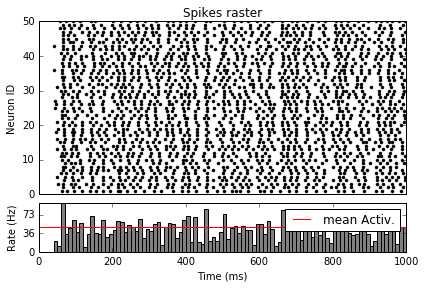

In [4]:
####### NEST Simulation #########
nest.ResetKernel() # reset NEST
nest.SetKernelStatus({'resolution': dt}) # set resolution
nest.SetDefaults('multimeter', {'interval':dt})
nest.SetDefaults('noise_generator', {'dt':dt})
nodes = nest.Create('iaf_psc_alpha',N) # create neurons
nest.SetStatus(nodes,{'V_th': u_th,'tau_m': t_m,'C_m': C_m,
                              'E_L':u_rest,'t_ref':t_ref,'V_m': u_rest,
                              'V_reset': u_reset,'I_e':I_ext,'tau_syn_ex':tau_syn_ex,
                               'tau_syn_in': tau_syn_in})
spikes = nest.Create('spike_detector') # create spikes detector
nest.Connect(nodes, spikes) #Connect node to spike detector
noise = nest.Create("poisson_generator",1,{'rate':r_ext*C_ext}) #create external noise background with rate r_ext(Hz)
nest.Connect(noise,nodes,syn_spec={'weight':W_ext/q,'delay':my_delay}) # Connect noise to network
nest.Connect(nodes,nodes,{'rule':'fixed_indegree','indegree':C_E},
             {'delay':my_delay,'weight':W_E/q})
nest.Simulate(simtime) #simulate

At = []
dSD = nest.GetStatus(spikes,keys='events')[0]
ts = np.arange(0., simtime,dt)
for i,t in enumerate(ts):
    a = ((t <= dSD['times']) & (dSD['times'] < (t+dt))).sum() #count spikes per bin
    At.append(a) 
At = np.array(At)/float(N)/dt*1000.  # empirical instantaneous activity At
print 'Mean activity: ',At.mean(),'[Hz]' #, 'mean: ',At.mean()

#### Plotting ####
nest.raster_plot.from_device(spikes, hist=True,grayscale=True,hist_binwidth=10.0,title='Spikes raster') # raster plot
data = nest.GetStatus(spikes,keys='events')[0]   
plt.axes([0.1, 0.1, 0.85, 0.17])
plt.plot([0.,simtime],[At.mean(),At.mean()],linewidth=1,color='red',label='mean Activ.')
plt.legend(loc='upper right')
plt.show()

In [5]:
# DipDe Settings:
t0 = 0.
dt = .0001#.00005
dv = .001 #.001
tf = 1.#.1
update_method = 'approx'
approx_order = 1
tol = 1e-14
verbose = False

/Users/carlosengutierrez/anaconda/lib/python2.7/site-packages/dipde/internals/internalpopulation.py:201: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Mean activity:  45.1402775782 [Hz]


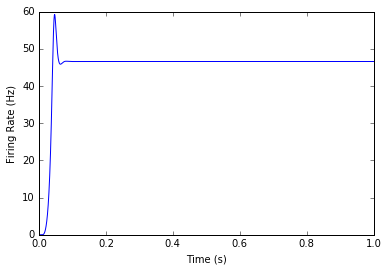

In [6]:
##### DipDe simulation #####
b1 = ExternalPopulation(r_ext, record=True)
i1 = InternalPopulation(tau_m = t_m*1e-3, v_min = u_reset*1e-3, v_max = u_th*1e-3,
                        dv=dv, update_method=update_method, approx_order=approx_order,
                        tol=tol,record=True, curr_firing_rate=0.0,norm='inf')

b1_i1 = Connection(b1, i1, C_ext, weights=[W_ext*1e-3], probs=[1.], delay = my_delay*1e-3)
i1_i1 = Connection(i1, i1,C_E , weights=[W_E*1e-3], probs=[1.], delay = my_delay*1e-3)

simulation = Simulation([b1, i1], [b1_i1, i1_i1], verbose=verbose)
simulation.run(dt=dt, tf=tf, t0=t0)

##############plotting #########
print 'Mean activity: ',np.array(i1.firing_rate_record).mean(),'[Hz]'
i1 = simulation.population_list[1]
plt.plot(i1.t_record, i1.firing_rate_record,'b-')
plt.xlim([0,tf])
plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.show()